# Compare between

* Baseline = tp0
* Loss with each channel weighted equally

## TL;DR

* Somehow, the 24 hour forecast error is significantly$^*$ lower with the channel loss
    * "Significantly" in the sense that this is just 10 samples, not evenly distributed from our validation set
    * This is more noticeable at higher vertical levels (although note this only goes to 500 hPa or so)
    * The only exception is `spfh2m` for which the baseline is slightly higher, maybe not significantly though.
* It looks like there is slightly more spectral bias with the channel loss
    * That is, the spectrum decays more
    * Is this bad though, because the slope actually looks closer to the truth?
    * Either way, maybe it is insignificant.
* The loss curves, after normalizing by (max - min) is basically the same between the two versions
* However, the loss is redistributed to favor 3D variables in the channel version, rather than 2D variables as in the original.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import jax
from tqdm.notebook import tqdm

from graphufs.datasets import Dataset
from graphufs.batchloader import BatchLoader

from graphufs.utils import get_last_input_mapping, swap_dims

from config import ChannelTester
from prototypes.tp0.config import TP0Tester

/home/tsmith/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [2]:
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [4]:
from functools import partial
import haiku as hk

from graphcast import rollout

from graphufs import construct_wrapped_graphcast
from graphufs.inference import swap_batch_time_dims

In [5]:
def predict(
    emulator,
    dataset,
    idx=0,
    ckpt_id=None,
) -> xr.Dataset:

    ckpt_id = emulator.num_epochs if ckpt_id is None else ckpt_id
    params, state = emulator.load_checkpoint(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    all_predictions = []
    all_targets = []
    for idx in tqdm(range(10)):
        inputs, targets, forcings = dataset.get_xarrays(idx)
        inputs.load()
        targets.load()
        forcings.load()
    
        # retrieve and drop t0
        inittimes = inputs.datetime.isel(time=-1).values
        inputs = inputs.drop_vars("datetime")
        targets = targets.drop_vars("datetime")
        forcings = forcings.drop_vars("datetime")
    
        predictions = rollout.chunked_prediction(
            gc,
            rng=jax.random.PRNGKey(0),
            inputs=inputs,
            targets_template=np.nan * targets,
            forcings=forcings,
        )
    
        # Add t0 as new variable, and swap out for logical sample/batch index
        predictions = swap_batch_time_dims(predictions, inittimes)
        targets = swap_batch_time_dims(targets, inittimes)
        all_predictions.append(predictions)
        all_targets.append(targets)

    all_predictions = xr.concat(all_predictions, dim="time")
    all_targets = xr.concat(all_targets, dim="time")

    return all_predictions, all_targets

In [8]:
experiments = {}
for Emulator, label in zip(
    [TP0Tester, ChannelTester],
    ["Baseline", "Channel Loss"],
):
    stuff = dict()
    stuff["emulator"] = Emulator()
    stuff["dataset"] = Dataset(stuff["emulator"], mode="validation")
    stuff["predictions"], stuff["targets"] = predict(
        emulator=stuff["emulator"],
        dataset=stuff["dataset"],
    )
    experiments[label] = stuff

  0%|          | 0/10 [00:00<?, ?it/s]

2024-11-01 16:12:51.132814: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.85MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18712576 bytes.

### Snapshots

In [ ]:
tkw = lambda ax: dict(ha="left", va="center", backgroundcolor="white", transform=ax.transAxes)

In [ ]:
def make_plot(vlist):
    nrows = 4
    ncols = len(vlist)
    fig, axs = plt.subplots(nrows, len(vlist), figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True, sharey=True)
    
    ilevel = 0
    itime = 1
    ilead = -1

    output_transforms = experiments["Baseline"]["emulator"].output_transforms
    
    for v, ax in zip(vlist, axs[1]):
        plotme = experiments["Baseline"]["targets"][v].isel(lead_time=ilead, time=itime).squeeze()
        if "level" in plotme.dims:
            plotme = plotme.isel(level=ilevel, drop=True)
        if v in output_transforms:
            plotme = output_transforms[v](plotme)
        plotme.plot(ax=ax, cbar_kwargs={"label": ""})
        ax.set(
            xlabel="",
            ylabel="Target" if ax.get_subplotspec().is_first_col() else "",
            title=v if ax.get_subplotspec().is_first_row() else "",
        )
    
    plotlist = {k : list() for k in vlist}

    for key, axr in zip(["Baseline", "Channel Loss"], [axs[0], axs[2]]):

        for v, ax in zip(vlist, axr):
            plotme = experiments[key]["predictions"][v].isel(lead_time=ilead, time=itime).squeeze()
            target = experiments[key]["targets"][v].isel(lead_time=ilead, time=itime).squeeze()
            if "level" in plotme.dims:
                plotme = plotme.isel(level=ilevel, drop=True)
                target = target.isel(level=ilevel, drop=True)
                
            if v in output_transforms:
                plotme = output_transforms[v](plotme)
                target = output_transforms[v](target)
    
            plotlist[v].append(plotme)
            mae = np.abs(plotme - target).mean().values
            plotme.plot(ax=ax, cbar_kwargs={"label": ""})
            ax.set(
                xlabel="",
                ylabel=key if ax.get_subplotspec().is_first_col() else "",
                title=v if ax.get_subplotspec().is_first_row() else "",
            )
            ax.text(.15, .1, f"MAE = {mae:1.1e}", **tkw(ax))
            if "spfh" in v:
                ngz = (plotme<0).sum().values
                tot = int(len(plotme.lat) * len(plotme.lon))
                ax.text(.15, .9, f"{ngz} / {tot} < 0", **tkw(ax))
    for v, ax in zip(vlist, axs[-1]):
        diff = plotlist[v][1] - plotlist[v][0]
        diff.plot(ax=ax)
        ax.set(
            xlabel="",
            ylabel="row3 - row1" if ax.get_subplotspec().is_first_col() else "",
            title="",
        )
    return fig, axs 

In [ ]:
make_plot(["tmp", "spfh", "tmp2m", "spfh2m"]);

In [ ]:
make_plot(["ugrd", "vgrd", "ugrd10m", "vgrd10m"]);

## Plot Error

In [ ]:
import seaborn as sns

In [ ]:
def plot_error(varlist):
    nrows=1
    ncols = len(varlist)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True)

    ilevel = 1 

    output_transforms = experiments["Baseline"]["emulator"].output_transforms

    for v, ax in zip(varlist, axs):
        for ii, key in enumerate(experiments.keys()):
            p = swap_dims(experiments[key]["predictions"][v])
            t = swap_dims(experiments[key]["targets"][v])
            
            if "level" in p.dims:
                p = p.isel(level=ilevel)
                t = t.isel(level=ilevel)

            if v in output_transforms:
                p = output_transforms[v](p)
                t = output_transforms[v](t)

            plotme = np.abs(p-t).mean(["lat", "lon"]).squeeze()

            sns.lineplot(
                plotme.to_dataframe().reset_index(),
                x="fhr",
                y=v,
                ax=ax,
                color=f"C{ii}",
                errorbar="sd",
                label=key,
                legend=False,
            )
        ax.set(title=v, xticks=list(x for x in range(0, 25, 6)))

    axs[-1].legend(loc="center left", bbox_to_anchor=(1, .5))
    return fig, axs

In [ ]:
plot_error(["tmp", "spfh", "tmp2m", "spfh2m"]);

In [ ]:
plot_error(["ugrd", "vgrd", "ugrd10m", "vgrd10m"]);

### Spectra

In [ ]:
def plot_spectra(vlist):
    ncols = len(vlist)
    fig, axs = plt.subplots(1, len(vlist), figsize=(ncols*5, 4), constrained_layout=True, sharex=True)
    
    ilevel = 1 
    itime = 0
    ilead = -1 
    
    output_transforms = experiments["Baseline"]["emulator"].output_transforms
    
    plotlist = {k : list() for k in vlist}
    for cid, key in enumerate(experiments.keys()):
        
        for v, ax in zip(vlist, axs):
            for xds, ls in zip(
                [experiments[key]["predictions"],
                 experiments[key]["targets"].copy(),
                ],
                ["-", ":"],
            ):
                computer = ZonalEnergySpectrum(v)
                plotme = xds[[v]].isel(time=itime).squeeze()
                plotme = plotme.rename({"lat": "latitude", "lon": "longitude"})
                if "level" in plotme.dims:
                    plotme = plotme.isel(level=ilevel, drop=True)
                plotme = plotme.isel(lead_time=ilead)
                if v in output_transforms:
                    plotme = output_transforms[v](plotme)
    
                plotme = plotme.compute()
                plotme = computer.compute(plotme)
                plotme = plotme.mean("latitude")
                plotme.plot(ax=ax, xscale="log", yscale="log", x="zonal_wavenumber", linestyle=ls, color=f"C{cid}", label=key)
            ax.set(title=v)
    axs[-1].legend(bbox_to_anchor=(1.1, .5), loc="center left")
    return fig, axs


In [ ]:
fig, axs = plot_spectra(["tmp", "spfh", "tmp2m", "spfh2m"])
axs[0].set(ylim=(1e4, 5e8))
#axs[1].set(ylim=(None, 1e1))
axs[2].set(ylim=(None, 3e9))
axs[3].set(ylim=(None, 1e2))


In [ ]:
fig, axs = plot_spectra(["ugrd", "vgrd", "ugrd10m", "vgrd10m"])

## Loss


In [ ]:
loss = {
    "Baseline": xr.open_dataset("../tp0/local-output/loss.nc"),
    "Channel Loss": xr.open_dataset("channel-loss-output/loss.nc"),
}

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharey=True)

for key, title, ax in zip(["loss_avg", "loss_valid"], ["Training Loss", "Validation Loss"], axs):
    for label, xds in loss.items():
        plotme = xds[key]
        plotme = plotme / (plotme.max() - plotme.min())
        plotme.plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
    ax.set(title=title, ylabel="Loss" if ax.get_subplotspec().is_first_row() else "")
    
axs[-1].legend(title="Loss rescaled by (max-min)", loc="center left", bbox_to_anchor=(1., .5))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)

key = "mgrad"
title = "Avg. |grad|"

for label, xds in loss.items():
    plotme = xds[key]
    plotme = plotme / (plotme.max() - plotme.min())
    plotme.plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
ax.set(title=title, ylabel="Avg. |grad|" if ax.get_subplotspec().is_first_row() else "")
    
ax.legend(title="Loss rescaled by (max-min)", loc="center left", bbox_to_anchor=(1., .5))

In [ ]:
from prototypes.tp0.config import TP0Emulator
from config import ChannelEmulator

In [ ]:
from graphufs.utils import get_channel_index

In [ ]:
def convert_loss_channel2var(Emulator, loss2d):
    """

    Args:
        Emulator: note that it has to be the training emulator
        loss2d (xr.DataArray): second axis just has to be "channel"
    """
    em = Emulator()
    tds = Dataset(em, mode="training")

    _, xtargets, _ = tds.get_xarrays(0)
    tmeta = get_channel_index(xtargets)

    varloss = {}
    for cidx in loss2d.channel.values:
        mymeta = tmeta[cidx]
        varname = mymeta["varname"]
        this_loss = loss2d.sel(channel=cidx, drop=True)
        this_loss.name = varname
        if "level" in mymeta:
            levelval = xtargets.level.isel(level=mymeta["level"]).values
            this_loss = this_loss.expand_dims({"level": [levelval]})
            if varname not in varloss:
                varloss[varname] = [this_loss]
            else:
                varloss[varname].append(this_loss)
        else:
            varloss[varname] = this_loss

    for key in xtargets.data_vars:
        if "level" in xtargets[key].dims:
            varloss[key] = xr.concat(varloss[key], dim="level")
    return xr.Dataset(varloss)


In [ ]:
vloss = {
    "Baseline": convert_loss_channel2var(TP0Emulator, loss["Baseline"]["loss_by_channel_valid"]),
    "Channel Loss": convert_loss_channel2var(ChannelEmulator, loss["Channel Loss"]["loss_by_channel_valid"]),
}

In [ ]:
vars3d = [v for v in vloss["Baseline"].data_vars if "level" in vloss["Baseline"][v].dims]
vars2d = [v for v in vloss["Baseline"].data_vars if "level" not in vloss["Baseline"][v].dims]
vars3d = ["tmp", "spfh", "ugrd", "vgrd"]
vars2d = ["tmp2m", "spfh2m", "ugrd10m", "vgrd10m", "pressfc"]

In [ ]:
def plot_panel(xds, key, level=None, donorm=True, **kwargs):
    plotme = xds[key]
    if level is not None:
        plotme = plotme.sel(level=level)
    if donorm:
        rng = (plotme.max()-plotme.min()).values
        plotme = plotme / rng
        print(f"{label}, {key}: range = {rng:1.1e}")
    plotme.plot.line(**kwargs)
    

NameError: name 'vloss' is not defined

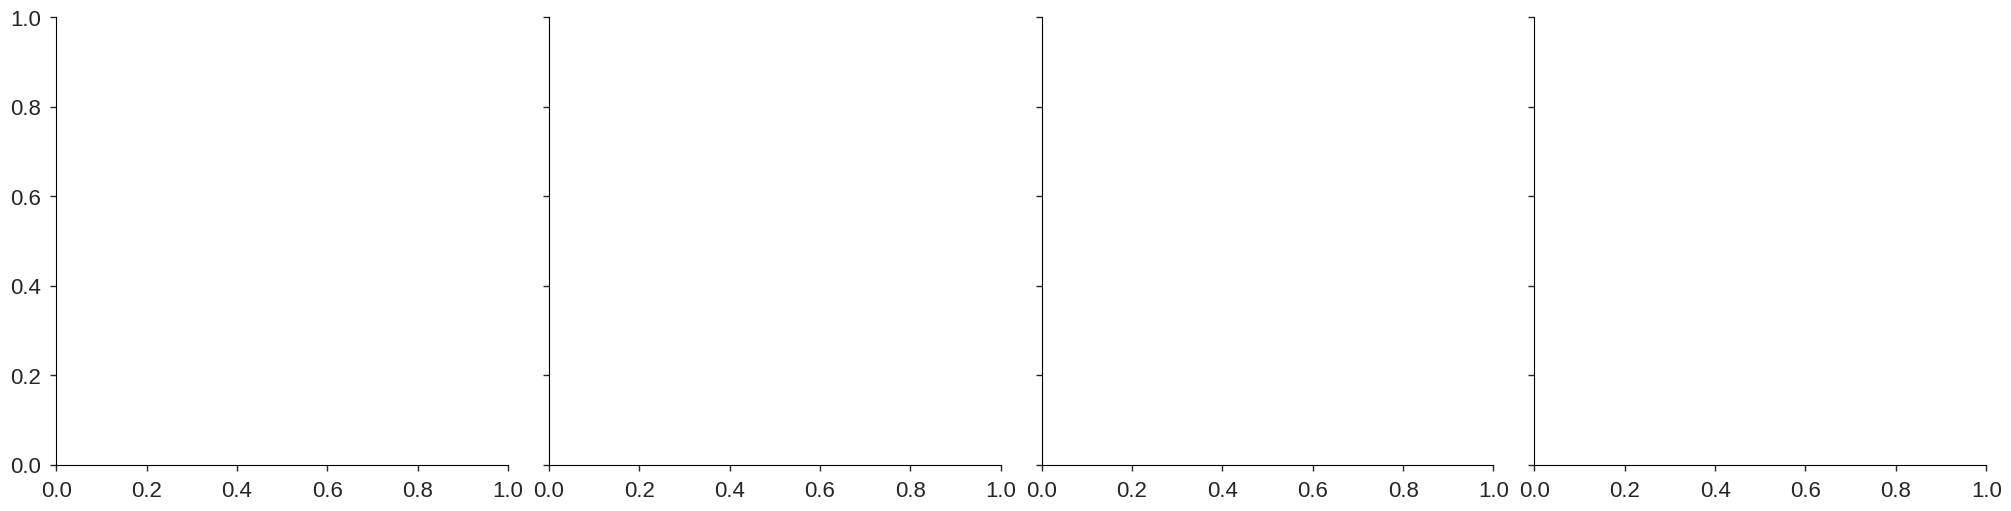

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True, sharey=True)

ax = axs[0]
for ls, (label, xds) in zip(["-", "--"], vloss.items()):
    for cid, key in enumerate(vars2d):
        plot_panel(
            xds=xds,
            key=key,
            x="epoch",
            ax=ax,
            ls=ls,
            label=key if ls=="-" else None,
            color=f"C{cid}",
        )
ax.set(ylabel="Loss")
ax.legend()
        
for level, ax in zip(xds.level.values[::-1], axs[1:]):
    for ls, (label, xds) in zip(["-", "--"], vloss.items()):
        for cid, key in enumerate(vars3d):
            plot_panel(
                xds=xds,
                key=key,
                level=level,
                x="epoch",
                ax=ax,
                ls=ls,
                label=key if ls=="-" else None,
                color=f"C{cid}",
            )
    ax.set(ylabel="")
    
   # kw = {}
   # if ax.get_subplotspec().is_last_col():
   #     kw["loc"] = "center left"
   #     kw["bbox_to_anchor"] = (1, .5)
axs[1].legend(title="Solid = Baseline\nDashed = Channel")

#axs[-1].legend(title="Loss rescaled by (max-min)", loc="center left", bbox_to_anchor=(1., .5))

Recall from earlier plot that the loss is basically the same, so here we are just seeing a redistribution of how the loss is weighted.

* 2D variables have a slightly higher loss with channel version
* 3D variables tend to have lower losses with the channel version except...
  * Biggest shift is in upper layers, these have biggest reduction in loss due to channel weighting
  * Especially in the velocity vectors
  * At the lowest model level (near surface), channel weighting results in slightly higher loss values for spfh
    similar to surface vars though, it's very close.

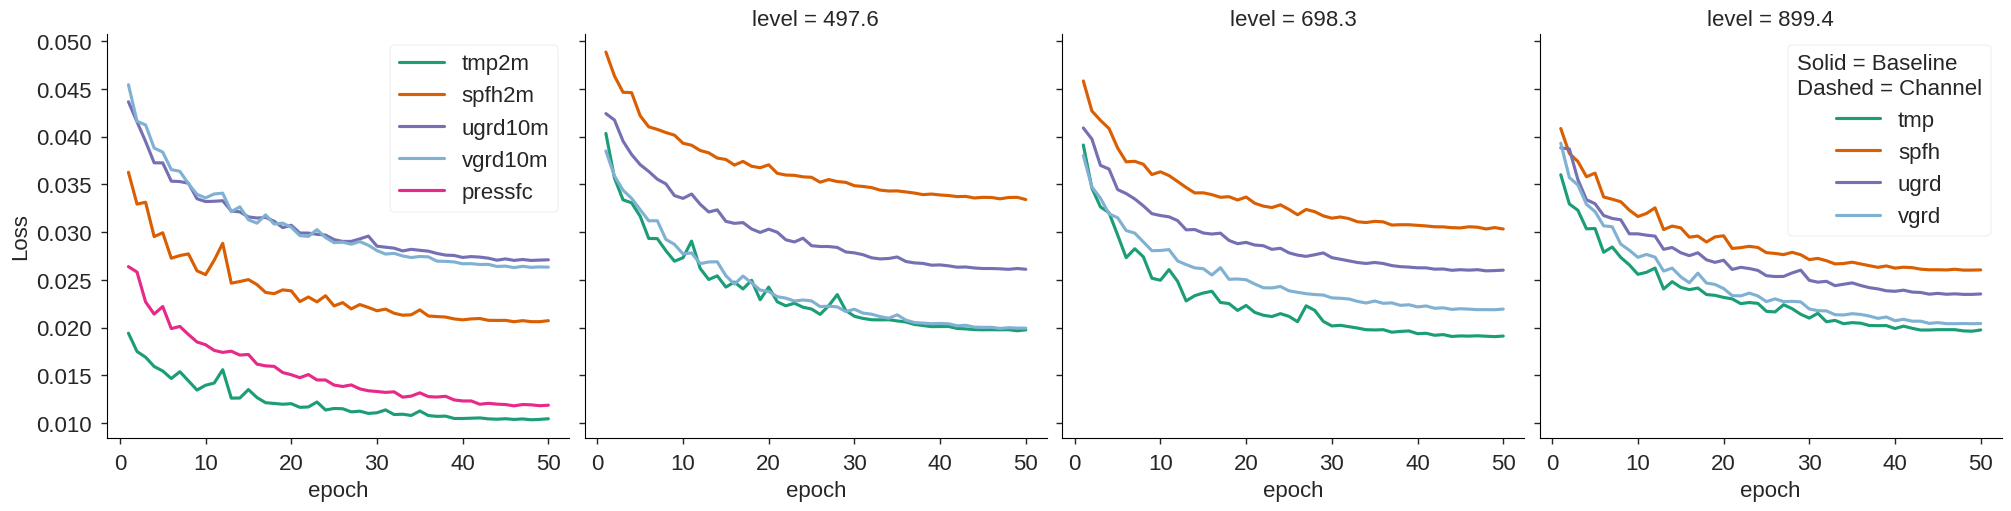

In [136]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True, sharey=True)

ax = axs[0]
ls = "-"
label = "Channel Loss"
xds = vloss[label]
for cid, key in enumerate(vars2d):
    plot_panel(
        xds=xds,
        key=key,
        donorm=False,
        x="epoch",
        ax=ax,
        ls=ls,
        label=key if ls=="-" else None,
        color=f"C{cid}",
    )
ax.set(ylabel="Loss")
ax.legend()
        
for level, ax in zip(xds.level.values, axs[1:]):
    for cid, key in enumerate(varlist):
        plot_panel(
            xds=xds,
            key=key,
            level=level,
            donorm=False,
            x="epoch",
            ax=ax,
            ls=ls,
            label=key if ls=="-" else None,
            color=f"C{cid}",
        )
    ax.set(ylabel="")
    
   # kw = {}
   # if ax.get_subplotspec().is_last_col():
   #     kw["loc"] = "center left"
   #     kw["bbox_to_anchor"] = (1, .5)
ax.legend(title="Solid = Baseline\nDashed = Channel")

#axs[-1].legend(title="Loss rescaled by (max-min)", loc="center left", bbox_to_anchor=(1., .5))

This plot shows the non normalized version from the channel loss.
Why do the vertical layer values have higher loss values? Is it because the surface values are so dependent on topography?